In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 📦 Importing Libraries and Setting Visual Styles

This block imports all necessary Python libraries for data manipulation and visualization:

- `pandas` and `numpy` for handling and processing datasets.
- `matplotlib.pyplot` and `seaborn` for static visualizations.
- `plotly.express` for interactive plots.
- `json` for parsing board layout strings.
- `LinearSegmentedColormap` for customizing color maps.

It also configures default styles:
- Applies a clean white-grid theme using Matplotlib.
- Sets Seaborn’s color palette to `"viridis"` for consistent plot coloring.
- Formats all float outputs in pandas to two decimal places for better readability.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px

# Configure visual settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
pd.options.display.float_format = '{:.2f}'.format

# 📂 Loading and Preparing Datasets

This block performs the initial data loading and preprocessing steps:

- Loads two CSV files:
  - `boards.csv`: contains board configurations (snakes and ladders) per `board_id`.
  - `game_journeys_turn_level.csv`: logs each turn of every game (per `game_id`).

- Parses the JSON-formatted columns (`snakes` and `ladders`) into Python lists using `json.loads`.

- Computes the total number of turns (`game_length`) for each game by grouping the journey data by `game_id` and taking the maximum `turn`.

- Merges the computed `game_length` back into the journey dataframe to enrich each row with full-game context.

- Finally, prints a quick summary:
  - Number of boards and games.
  - Total number of turns.
  - Average turns per game.


In [3]:
# Load datasets
boards_df = pd.read_csv('/content/drive/MyDrive/SnakesAndLadders/Data/boards.csv')
journeys_df = pd.read_csv('/content/drive/MyDrive/SnakesAndLadders/Data/game_journeys_turn_level.csv')

# Parse JSON columns
boards_df['snakes'] = boards_df['snakes'].apply(json.loads)
boards_df['ladders'] = boards_df['ladders'].apply(json.loads)

# Add game length calculation
game_lengths = journeys_df.groupby('game_id')['turn'].max().reset_index(name='game_length')
journeys_df = journeys_df.merge(game_lengths, on='game_id')

print(f"Boards: {boards_df.shape[0]}, Games: {journeys_df['game_id'].nunique()}")
print(f"Turns: {journeys_df.shape[0]}, Avg. turns/game: {journeys_df['game_length'].mean():.1f}")

Boards: 100, Games: 100000
Turns: 2979201, Avg. turns/game: 62.7


# 🎲 Analyzing Board Structures: Snakes and Ladders

This block calculates descriptive statistics for each board's configuration and visualizes them:

- **Metrics Computed:**
  - `n_snakes`: Total number of snakes on each board.
  - `n_ladders`: Total number of ladders on each board.
  - `avg_snake_length`: Average length (head - tail) of snakes on each board.
  - `avg_ladder_length`: Average length (top - bottom) of ladders on each board.

- **Visualizations (2×2 subplot layout):**
  - Top-left: Bar chart of how frequently different snake counts appear across boards.
  - Top-right: Bar chart of ladder count distribution across boards.
  - Bottom-left: Histogram of average snake lengths.
  - Bottom-right: Histogram of average ladder lengths.

These plots help understand how varied or uniform the boards are in terms of complexity and opportunity.


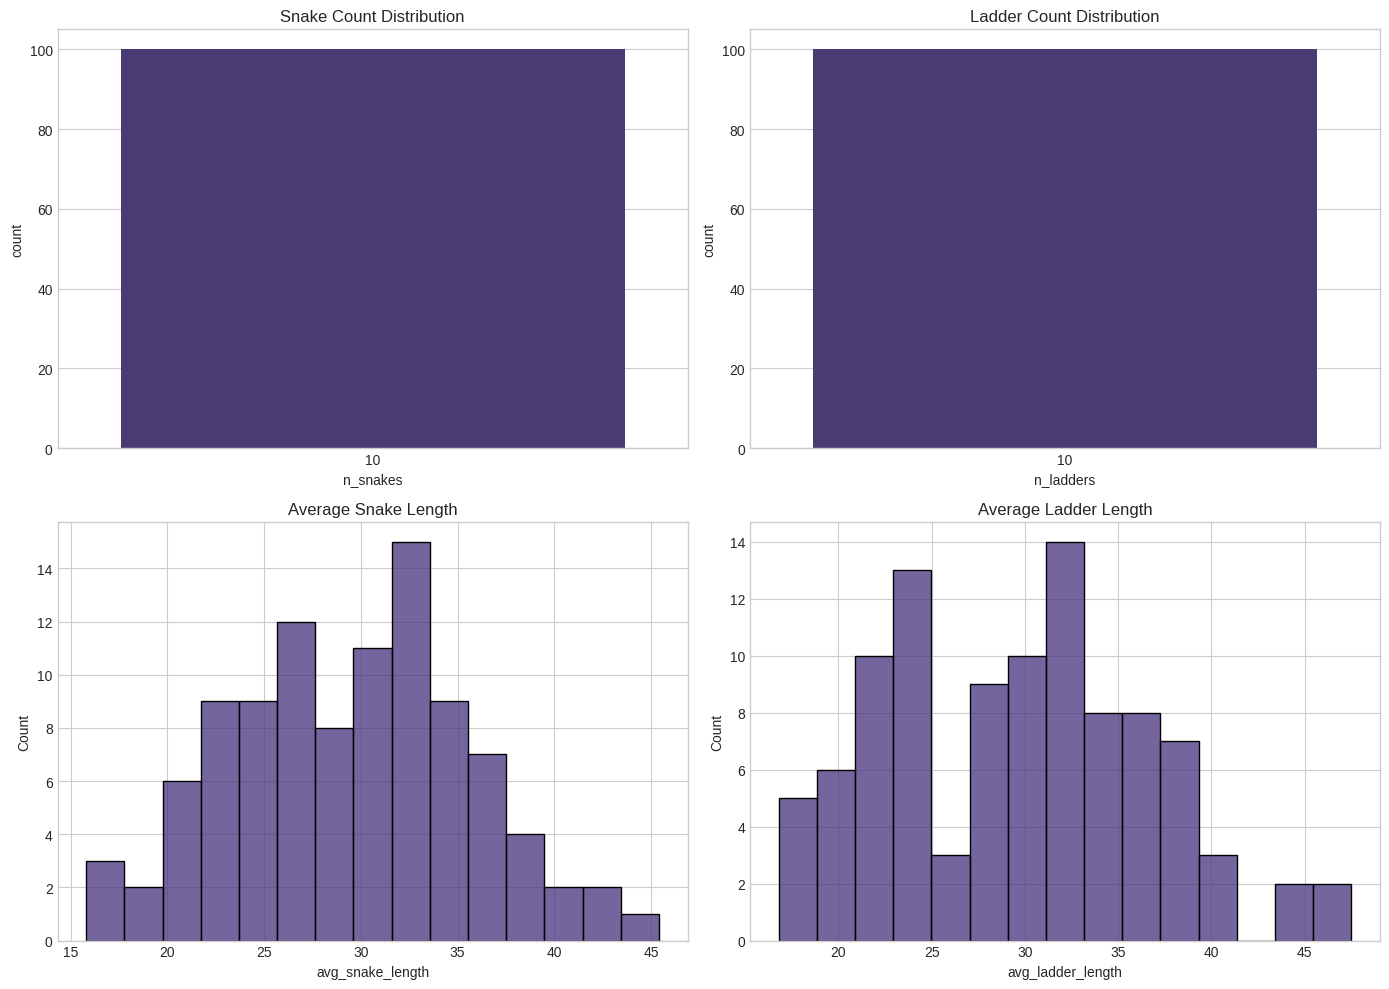

In [4]:
# Calculate snake and ladder metrics
boards_df['n_snakes'] = boards_df['snakes'].apply(len)
boards_df['n_ladders'] = boards_df['ladders'].apply(len)
boards_df['avg_snake_length'] = boards_df['snakes'].apply(
    lambda x: np.mean([start-end for start, end in x]))
boards_df['avg_ladder_length'] = boards_df['ladders'].apply(
    lambda x: np.mean([end-start for start, end in x]))

# Plot board features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Snake and ladder counts
sns.countplot(data=boards_df, x='n_snakes', ax=axes[0,0])
axes[0,0].set_title('Snake Count Distribution')
sns.countplot(data=boards_df, x='n_ladders', ax=axes[0,1])
axes[0,1].set_title('Ladder Count Distribution')

# Snake and ladder lengths
sns.histplot(data=boards_df, x='avg_snake_length', bins=15, ax=axes[1,0])
axes[1,0].set_title('Average Snake Length')
sns.histplot(data=boards_df, x='avg_ladder_length', bins=15, ax=axes[1,1])
axes[1,1].set_title('Average Ladder Length')

plt.tight_layout()
plt.show()

# ⏱️ How Board Features Affect Game Duration

This block explores the relationship between board design and how long games take to finish:

- Ensures that each `game_length` (number of turns) is associated with its corresponding `board_id`.

- Merges board-level features (`avg_snake_length`, `n_snakes`, `n_ladders`) with the **average game length per board**.

- Creates a scatter plot where:
  - X-axis: Average snake length on the board.
  - Y-axis: Average number of turns (i.e., game length).
  - Point size: Number of snakes on the board.
  - Point color: Number of ladders on the board (encoded using a `viridis` color palette).

This visual helps identify trends such as whether longer snakes or more ladders typically lead to shorter or longer games.


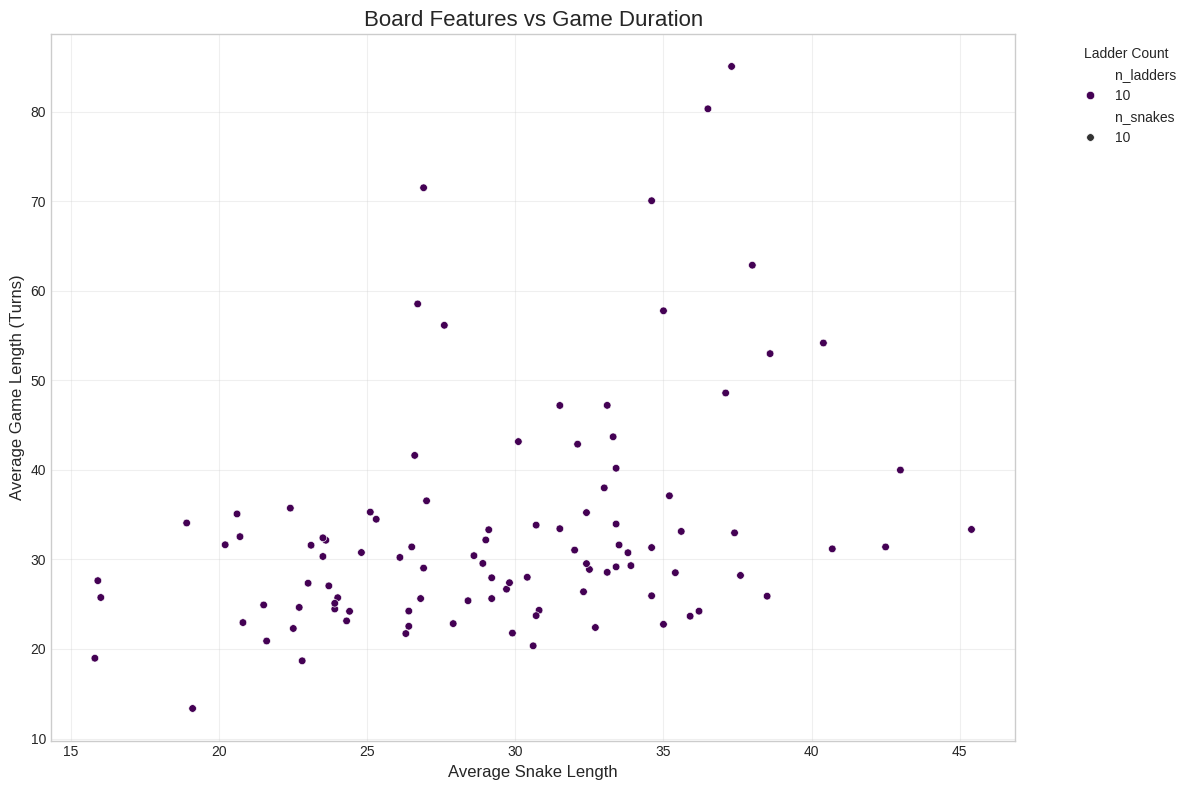

In [6]:
# Duration vs. board features (Corrected)
# First ensure we have board_id in game_lengths
if 'board_id' not in game_lengths.columns:
    game_info = journeys_df[['game_id', 'board_id']].drop_duplicates()
    game_lengths = game_lengths.merge(game_info, on='game_id')

merged = boards_df.merge(game_lengths.groupby('board_id')['game_length'].mean().reset_index(), on='board_id')

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=merged,
    x='avg_snake_length',
    y='game_length',
    size='n_snakes',
    hue='n_ladders',
    sizes=(30, 200),
    palette='viridis'
)
plt.title('Board Features vs Game Duration', fontsize=16)
plt.xlabel('Average Snake Length', fontsize=12)
plt.ylabel('Average Game Length (Turns)', fontsize=12)
plt.legend(title='Ladder Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 🎲 Dice Roll Patterns and Success Rates

This block analyzes the behavior and effectiveness of dice rolls during the game:

- **Roll Distribution Plot:**
  - A countplot showing how frequently each dice value (1–6) was rolled across all turns.
  - This helps confirm that the die is uniformly random.

- **Roll Success Rate Calculation:**
  - Calculates the probability that a roll from a given `start_pos` results in a valid move (i.e., does not overshoot position 100).
  - Groups by `start_pos` and uses the logic: `roll ≤ (100 - current_position)`.

- **Success Rate Visualization:**
  - Line plot showing the success rate as a function of board position.
  - Includes a vertical red dashed line at position 94, highlighting the "critical zone" near the end of the board where many rolls may overshoot and thus be invalid.

Together, these plots reveal player behavior dynamics and constraints in the final stretch of the game.


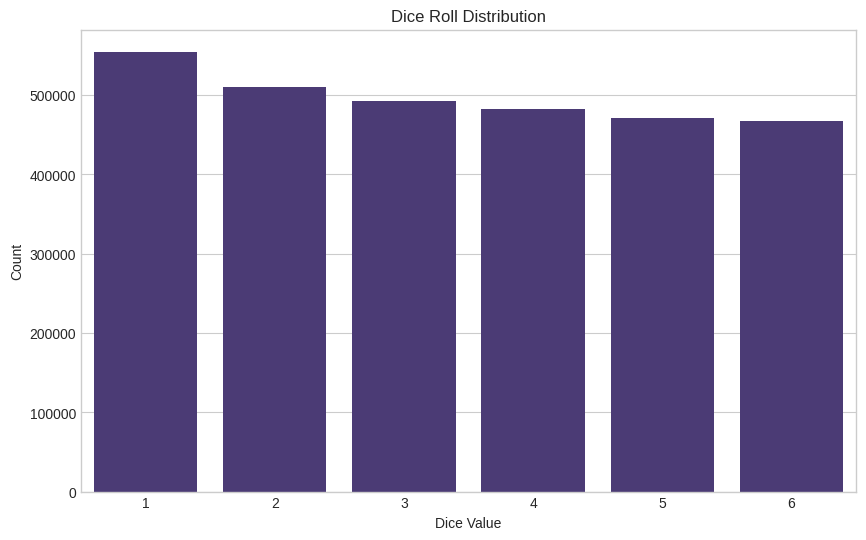

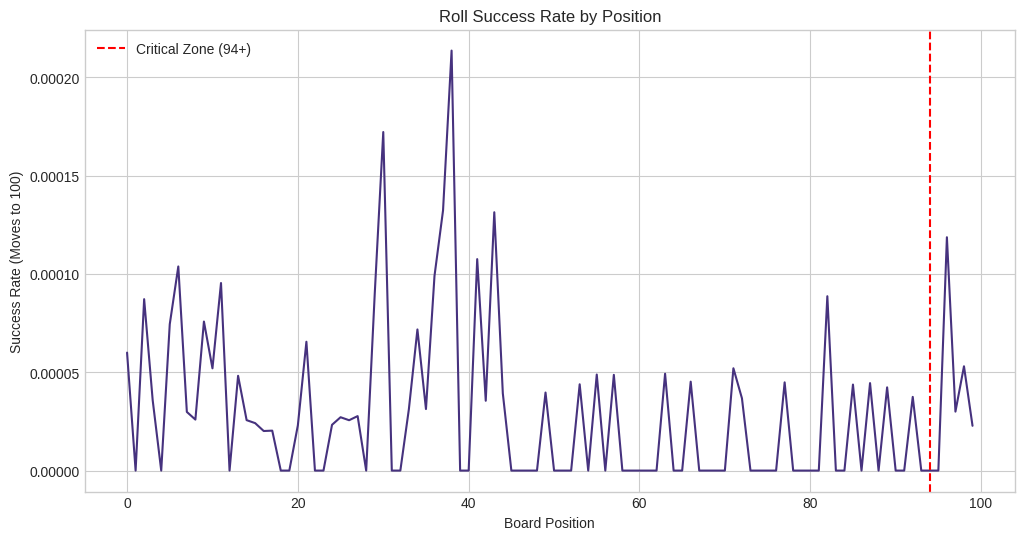

In [7]:
# Roll distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=journeys_df, x='roll')
plt.title('Dice Roll Distribution')
plt.xlabel('Dice Value')
plt.ylabel('Count')

# Roll success rate
success_rate = journeys_df.groupby('start_pos')['roll'].apply(
    lambda x: (x <= (100 - x.index)).mean()).reset_index(name='success_rate')

plt.figure(figsize=(12, 6))
sns.lineplot(data=success_rate, x='start_pos', y='success_rate')
plt.title('Roll Success Rate by Position')
plt.xlabel('Board Position')
plt.ylabel('Success Rate (Moves to 100)')
plt.axvline(94, color='r', linestyle='--', label='Critical Zone (94+)')
plt.legend()
plt.show()

# 🔄 Move Types and Position Transitions

This block investigates the types of movements and how players progress across board positions:

- **Move Type Distribution (Pie Chart):**
  - Visualizes the proportion of different move types:
    - `normal`: simple dice advance.
    - `ladder`: climbed up.
    - `snake`: slid down.
  - Provides insight into how often players encounter snakes and ladders versus just moving forward.

- **Position Transition Heatmap:**
  - Calculates the frequency of transitions from `start_pos` to `end_pos` for all turns.
  - Constructs a matrix where each cell indicates how many times a specific movement occurred between two positions.
  - Visualized as a heatmap to identify hotspots where movement is common (e.g., frequent ladder boosts or snake drops).

These plots help decode the structure of gameplay flow and where critical board activity is concentrated.


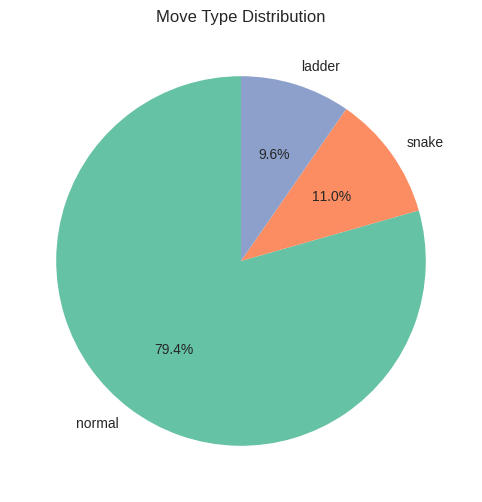

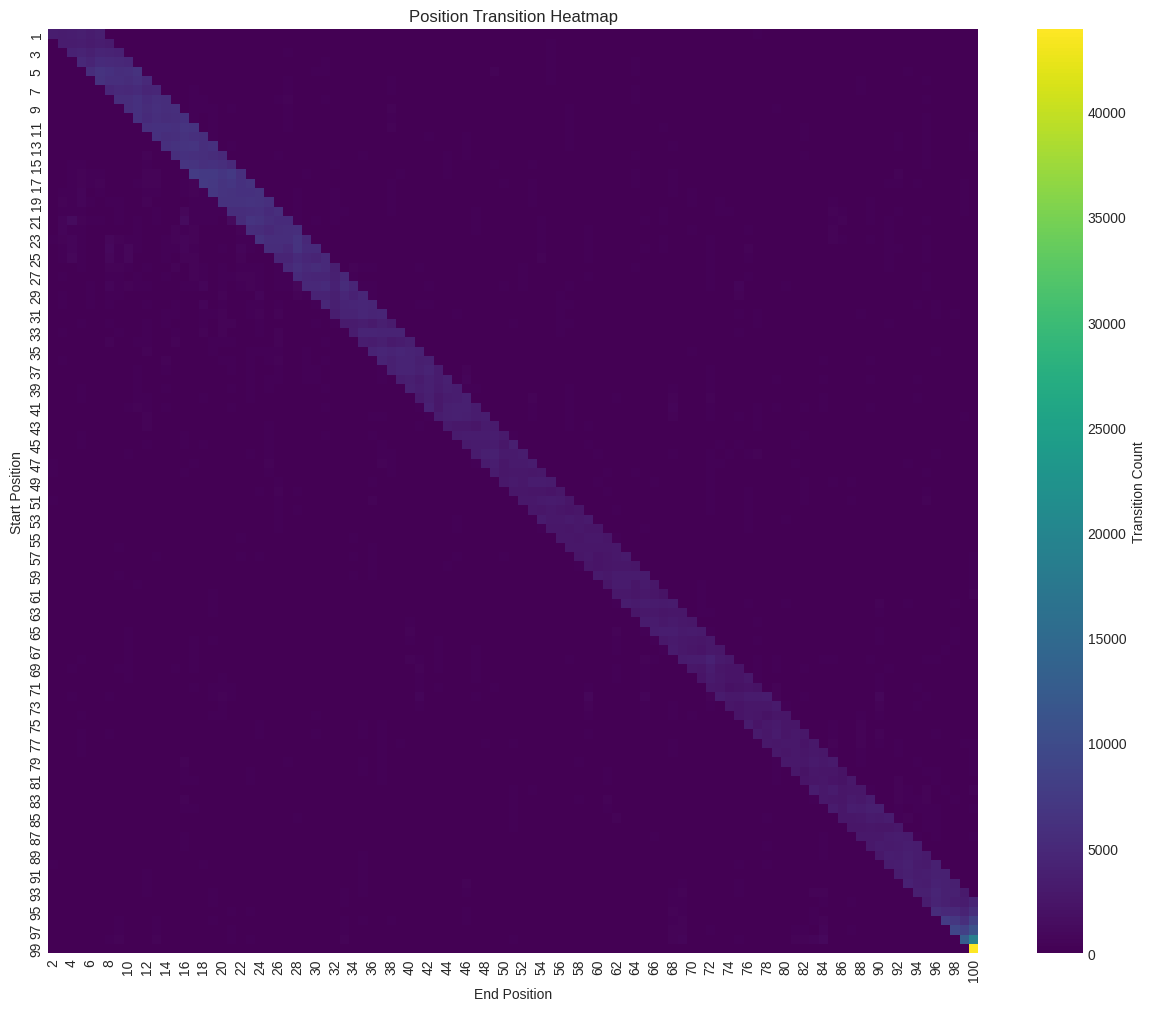

In [8]:
# Event type distribution
event_counts = journeys_df['move_type'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(event_counts, labels=event_counts.index, autopct='%1.1f%%',
        colors=['#66c2a5', '#fc8d62', '#8da0cb'], startangle=90)
plt.title('Move Type Distribution')
plt.show()

# Position transition heatmap
transitions = journeys_df.groupby(['start_pos', 'end_pos']).size().reset_index(name='count')
transitions_pivot = transitions.pivot_table(index='start_pos', columns='end_pos', values='count', fill_value=0)

plt.figure(figsize=(15, 12))
sns.heatmap(transitions_pivot.iloc[1:100, 1:100], cmap='viridis', cbar_kws={'label': 'Transition Count'})
plt.title('Position Transition Heatmap')
plt.xlabel('End Position')
plt.ylabel('Start Position')
plt.show()

# 🧭 Interactive 3D Visualization of Snakes and Ladders

This block creates an interactive 3D scatter plot to visualize the positions and types of board features across all boards:

- **Data Preparation:**
  - Extracts all snake and ladder coordinates across all boards.
  - Adds a `type` label (`"snake"` or `"ladder"`) and a `z` value to distinguish between them in 3D space (e.g., snakes at `z=0`, ladders at `z=1`).

- **Plot Construction:**
  - Uses `Plotly Express` to create a 3D scatter plot.
  - X-axis: starting position of the snake/ladder.
  - Y-axis: ending position of the snake/ladder.
  - Z-axis: feature type (0 = snake, 1 = ladder).
  - Color-coded by feature type (red for snakes, green for ladders).
  - Hover tooltips show the feature type and positions.

This interactive visualization helps explore the overall layout and distribution of snakes and ladders from a bird’s-eye view, making patterns and clustering easy to detect.


In [11]:
# Interactive 3D board visualization (snakes/ladders)
all_snakes = [item for sublist in boards_df['snakes'] for item in sublist]
all_ladders = [item for sublist in boards_df['ladders'] for item in sublist]

# Create DataFrames with type indicators
snakes_df = pd.DataFrame(all_snakes, columns=['start', 'end'])
snakes_df['type'] = 'snake'
snakes_df['z'] = 0  # Create z-column for snakes

ladders_df = pd.DataFrame(all_ladders, columns=['start', 'end'])
ladders_df['type'] = 'ladder'
ladders_df['z'] = 1  # Create z-column for ladders

# Combine both DataFrames
events_df = pd.concat([snakes_df, ladders_df])

# Create 3D plot
fig = px.scatter_3d(
    events_df,
    x='start',
    y='end',
    z='z',  # Now using the column we created
    color='type',
    color_discrete_map={'snake': 'red', 'ladder': 'green'},
    title='Snake and Ladder Distribution',
    labels={'start': 'Start Position', 'end': 'End Position', 'z': 'Feature Type'},
    opacity=0.7,
    hover_name='type',
    hover_data={'start': True, 'end': True, 'z': False}  # Hide z in hover
)

# Customize z-axis
fig.update_layout(
    scene=dict(
        zaxis=dict(
            tickvals=[0, 1],
            ticktext=['Snakes', 'Ladders'],
            title='Feature Type',
            range=[-0.5, 1.5]
        ),
    ),
    legend_title_text='Feature Type'
)

fig.show()

# 📊 Statistical Testing and Regression Analysis

This block applies inferential statistics to examine how game dynamics and board features influence game length:

- **T-Test for Game Events:**
  - Categorizes games based on whether they included any snake or ladder events.
  - Performs a two-sample independent t-test comparing the average game lengths of:
    - Games *with* events (snakes or ladders).
    - Games *without* any such events.
  - Outputs the t-statistic and p-value to assess statistical significance.

- **Linear Regression Model:**
  - Builds an Ordinary Least Squares (OLS) regression using `statsmodels`.
  - Predicts average game length (`game_length`) from:
    - Number of snakes and ladders.
    - Average snake and ladder lengths.
  - Includes a constant (intercept) term.
  - Prints the full regression summary, including coefficients, p-values, R-squared, and diagnostic statistics.

These analyses provide evidence of how board complexity affects game duration and whether event-heavy games tend to be longer or shorter.


In [12]:
from scipy import stats

# Compare game lengths with/without events
has_events = journeys_df.groupby('game_id')['move_type'].apply(
    lambda x: x.isin(['snake','ladder']).any()).reset_index(name='has_events')
merged_events = game_lengths.merge(has_events, on='game_id')

# T-test for game length difference
no_event = merged_events[merged_events['has_events'] == False]['game_length']
with_event = merged_events[merged_events['has_events'] == True]['game_length']
t_stat, p_value = stats.ttest_ind(no_event, with_event, equal_var=False)

print(f"Games without events: {len(no_event)}")
print(f"Games with events: {len(with_event)}")
print(f"T-test: t-statistic = {t_stat:.2f}, p-value = {p_value:.4f}")

# Regression analysis
import statsmodels.api as sm

X = merged[['n_snakes', 'n_ladders', 'avg_snake_length', 'avg_ladder_length']]
X = sm.add_constant(X)
y = merged['game_length']

model = sm.OLS(y, X).fit()
print(model.summary())

Games without events: 51
Games with events: 99949
T-test: t-statistic = -1.31, p-value = 0.1945
                            OLS Regression Results                            
Dep. Variable:            game_length   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     15.66
Date:                Thu, 31 Jul 2025   Prob (F-statistic):           1.28e-06
Time:                        16:08:58   Log-Likelihood:                -382.41
No. Observations:                 100   AIC:                             770.8
Df Residuals:                      97   BIC:                             778.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

# 📈 Interpretation of Statistical Test and Regression Output

#### 🧪 T-Test Results
- **Games without events:** 51
- **Games with events:** 99,949
- **T-statistic:** -1.31
- **P-value:** 0.1945

This indicates **no statistically significant difference** in average game length between games that encountered snakes or ladders and those that didn’t. A p-value above 0.05 suggests we fail to reject the null hypothesis — i.e., the presence of events does not significantly affect game duration.

---

#### 📉 OLS Regression Results

The regression model aims to explain the **average game length** using board characteristics:

| Feature               | Coefficient | Interpretation |
|-----------------------|-------------|----------------|
| `n_snakes`            | **+1.62**   | Each additional snake increases average game length by ~1.62 turns. |
| `n_ladders`           | **+1.62**   | Each additional ladder also increases duration by ~1.62 turns — likely due to more time to reach the top safely but also the possibility of circular progress. |
| `avg_snake_length`    | **+0.65**   | Longer snakes result in longer games. |
| `avg_ladder_length`   | **–0.62**   | Longer ladders help finish the game faster. |

- **R-squared = 0.244:** The model explains ~24.4% of the variance in game length.
- **All p-values < 0.01 for coefficients:** The relationships are statistically significant.
- **Multicollinearity Warning:** The near-identical coefficients for `n_snakes` and `n_ladders` and the condition number warning (`1.21e+16`) indicate possible **multicollinearity**, meaning these predictors are strongly correlated and may distort interpretation.

---

**Conclusion:**  
- Board features have a measurable and statistically significant impact on game length.
- More and longer snakes make games longer.
- Longer ladders reduce duration.
- But extreme correlation between features (e.g., same number of snakes and ladders per board) may require dimensionality reduction or feature separation for more robust inference.


# 🎮 Visualizing Game Progression for 10 Random Games

This block plots detailed turn-by-turn trajectories for 10 randomly selected games to visually analyze how players progress across the board:

- **Game Selection & Setup:**
  - Randomly selects 10 `game_id`s from the full dataset.
  - Prepares a color palette to assign a unique color to each game line.

- **Trajectory Plotting:**
  - For each sampled game, plots the player’s `end_pos` (board position) over `turn` number.
  - Highlights positions where players encountered:
    - **Snakes** (in red)
    - **Ladders** (in green)

- **Additional Visual Elements:**
  - A horizontal gold dashed line marks position 100 (win condition).
  - Adds a legend for clarity and annotations showing average turns taken among the selected games.

- **Purpose:**
  - This visual captures gameplay dynamics — abrupt drops (snakes), quick climbs (ladders), and differences in game lengths.
  - Ideal for qualitative insight into game variability and event impact on progress.


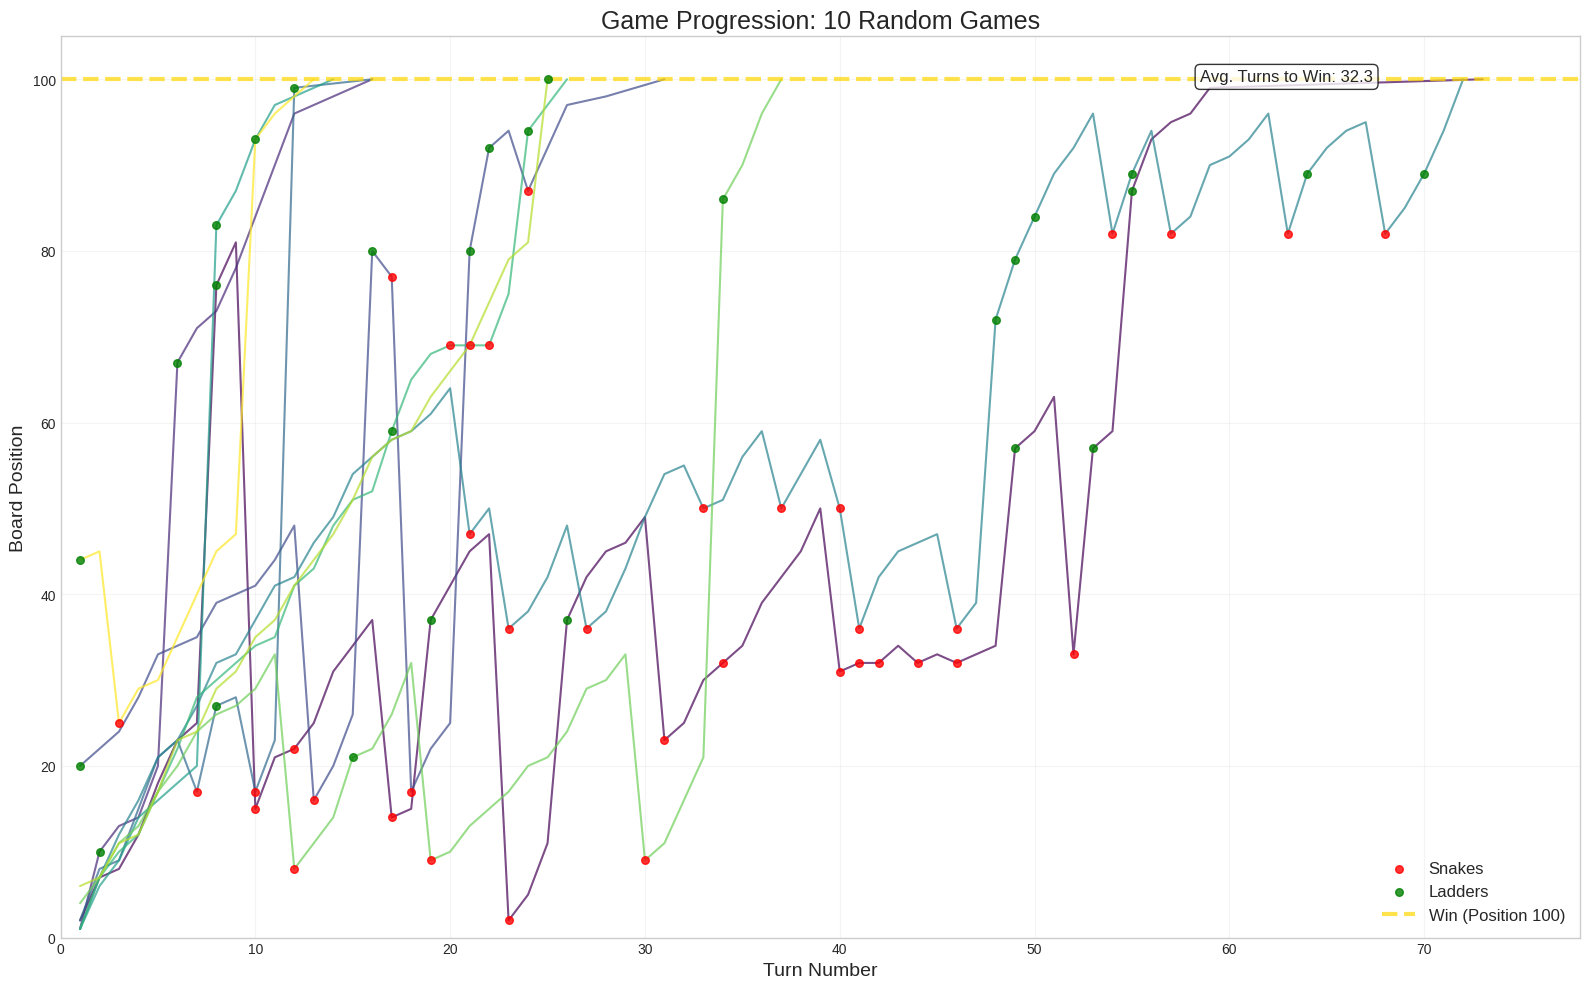

In [19]:
import random

# Sample 10 random games
sampled_games = random.sample(journeys_df['game_id'].unique().tolist(), 10)
sampled_journeys = journeys_df[journeys_df['game_id'].isin(sampled_games)]

# Create a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(sampled_games)))

plt.figure(figsize=(16, 10))
for i, game in enumerate(sampled_games):
    game_data = sampled_journeys[sampled_journeys['game_id'] == game]
    plt.plot(game_data['turn'], game_data['end_pos'],
             color=colors[i], alpha=0.7, linewidth=1.5)

# Add special markers for snakes and ladders
snake_points = sampled_journeys[sampled_journeys['move_type'] == 'snake']
ladder_points = sampled_journeys[sampled_journeys['move_type'] == 'ladder']

plt.scatter(snake_points['turn'], snake_points['end_pos'],
            color='red', s=30, alpha=0.8, label='Snakes', zorder=5)
plt.scatter(ladder_points['turn'], ladder_points['end_pos'],
            color='green', s=30, alpha=0.8, label='Ladders', zorder=5)

# Add target line
plt.axhline(100, color='gold', linestyle='--', linewidth=3, alpha=0.7, label='Win (Position 100)')

# Formatting
plt.title('Game Progression: 10 Random Games', fontsize=18)
plt.xlabel('Turn Number', fontsize=14)
plt.ylabel('Board Position', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.2)
plt.ylim(0, 105)
plt.xlim(0, sampled_journeys['turn'].max() + 5)

# Add statistical annotations
mean_turns = sampled_journeys.groupby('game_id')['turn'].max().mean()
plt.annotate(f'Avg. Turns to Win: {mean_turns:.1f}',
             xy=(0.75, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'))

plt.tight_layout()
plt.show()

# For 100 Random Games

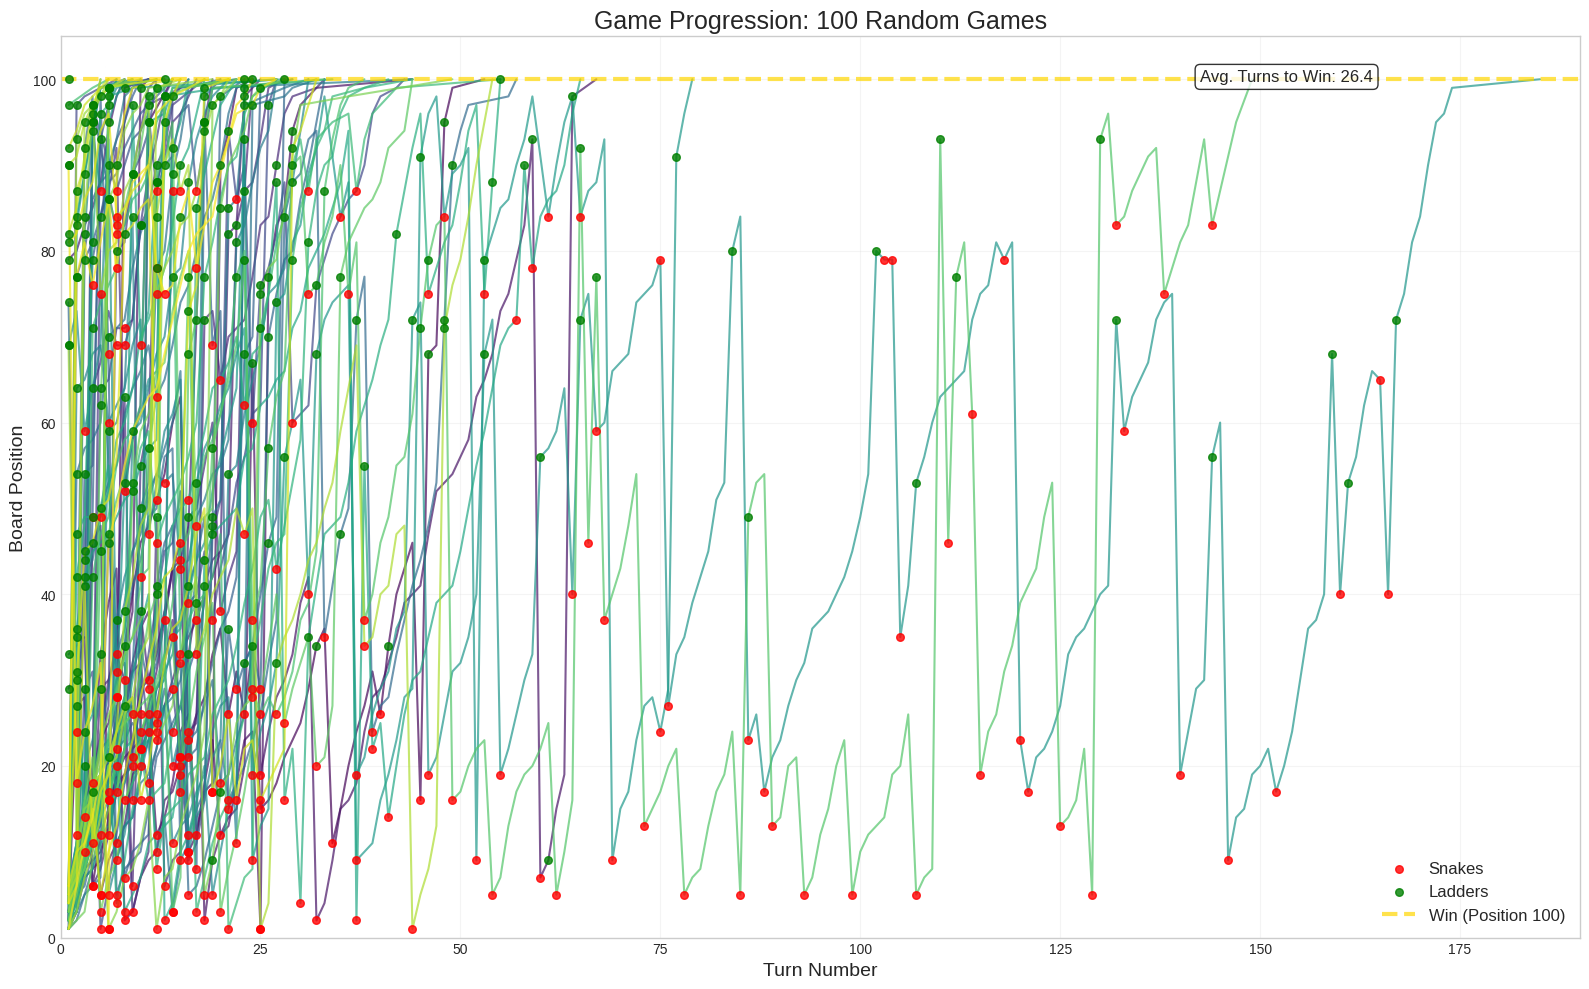

In [18]:
# Sample 100 random games
sampled_games = random.sample(journeys_df['game_id'].unique().tolist(), 100)
sampled_journeys = journeys_df[journeys_df['game_id'].isin(sampled_games)]

# Create a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(sampled_games)))

plt.figure(figsize=(16, 10))
for i, game in enumerate(sampled_games):
    game_data = sampled_journeys[sampled_journeys['game_id'] == game]
    plt.plot(game_data['turn'], game_data['end_pos'],
             color=colors[i], alpha=0.7, linewidth=1.5)

# Add special markers for snakes and ladders
snake_points = sampled_journeys[sampled_journeys['move_type'] == 'snake']
ladder_points = sampled_journeys[sampled_journeys['move_type'] == 'ladder']

plt.scatter(snake_points['turn'], snake_points['end_pos'],
            color='red', s=30, alpha=0.8, label='Snakes', zorder=5)
plt.scatter(ladder_points['turn'], ladder_points['end_pos'],
            color='green', s=30, alpha=0.8, label='Ladders', zorder=5)

# Add target line
plt.axhline(100, color='gold', linestyle='--', linewidth=3, alpha=0.7, label='Win (Position 100)')

# Formatting
plt.title('Game Progression: 100 Random Games', fontsize=18)
plt.xlabel('Turn Number', fontsize=14)
plt.ylabel('Board Position', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.2)
plt.ylim(0, 105)
plt.xlim(0, sampled_journeys['turn'].max() + 5)

# Add statistical annotations
mean_turns = sampled_journeys.groupby('game_id')['turn'].max().mean()
plt.annotate(f'Avg. Turns to Win: {mean_turns:.1f}',
             xy=(0.75, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'))

plt.tight_layout()
plt.show()

# For 1000 Random Games

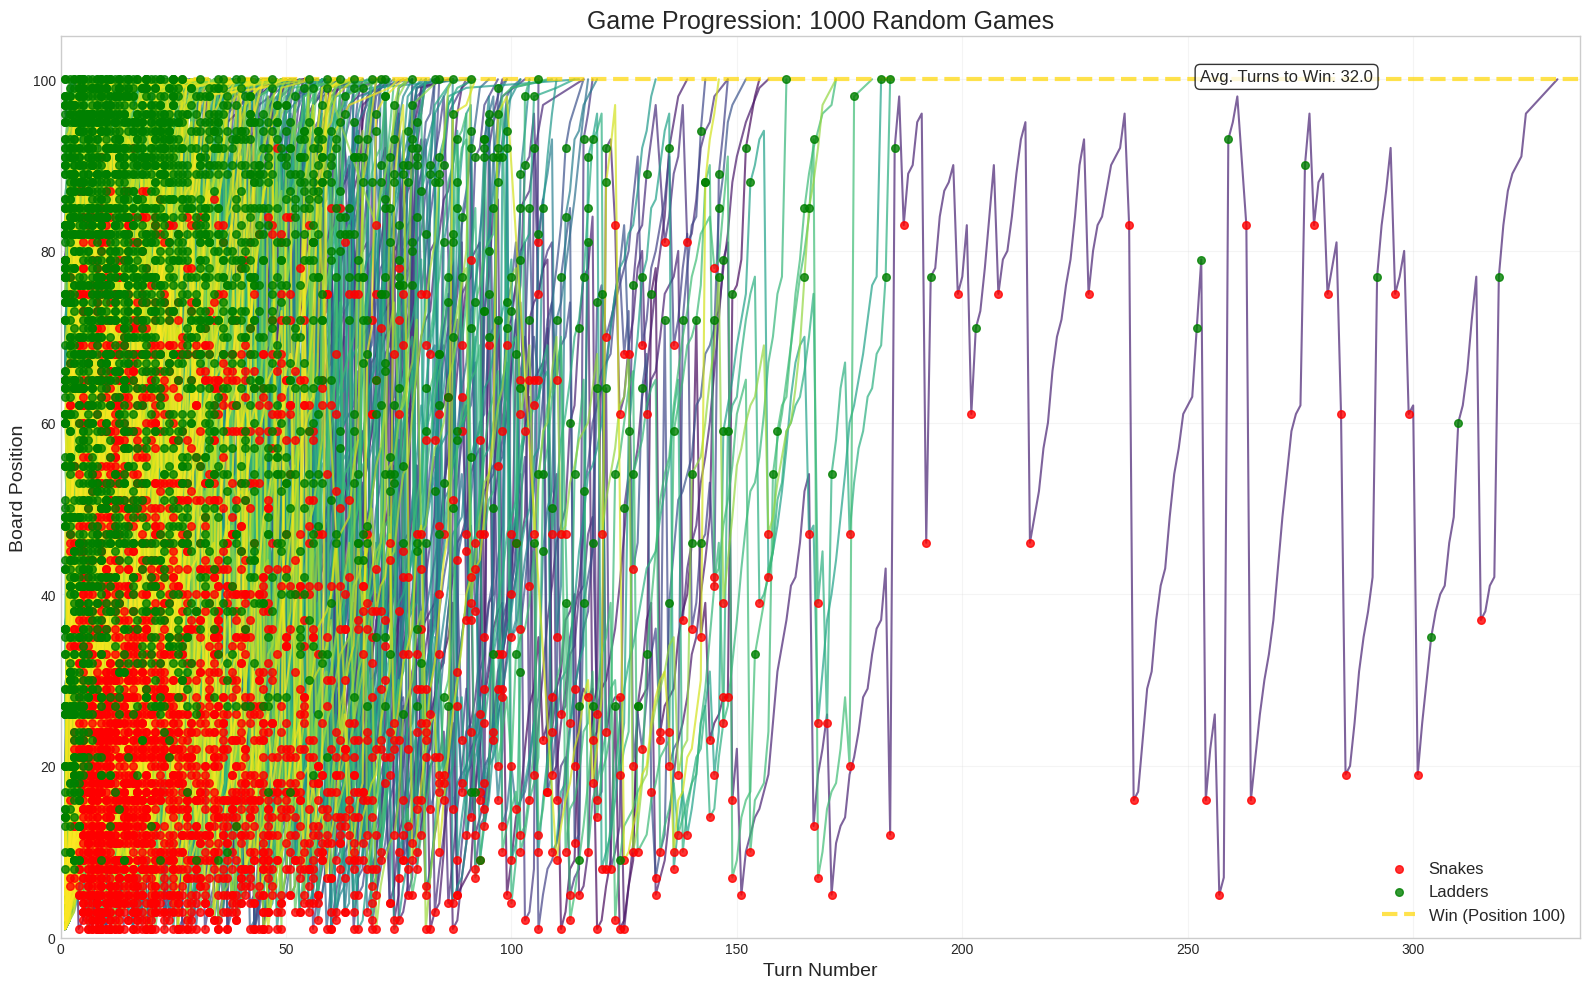

In [20]:
# Sample 1000 random games
sampled_games = random.sample(journeys_df['game_id'].unique().tolist(), 1000)
sampled_journeys = journeys_df[journeys_df['game_id'].isin(sampled_games)]

# Create a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(sampled_games)))

plt.figure(figsize=(16, 10))
for i, game in enumerate(sampled_games):
    game_data = sampled_journeys[sampled_journeys['game_id'] == game]
    plt.plot(game_data['turn'], game_data['end_pos'],
             color=colors[i], alpha=0.7, linewidth=1.5)

# Add special markers for snakes and ladders
snake_points = sampled_journeys[sampled_journeys['move_type'] == 'snake']
ladder_points = sampled_journeys[sampled_journeys['move_type'] == 'ladder']

plt.scatter(snake_points['turn'], snake_points['end_pos'],
            color='red', s=30, alpha=0.8, label='Snakes', zorder=5)
plt.scatter(ladder_points['turn'], ladder_points['end_pos'],
            color='green', s=30, alpha=0.8, label='Ladders', zorder=5)

# Add target line
plt.axhline(100, color='gold', linestyle='--', linewidth=3, alpha=0.7, label='Win (Position 100)')

# Formatting
plt.title('Game Progression: 1000 Random Games', fontsize=18)
plt.xlabel('Turn Number', fontsize=14)
plt.ylabel('Board Position', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.2)
plt.ylim(0, 105)
plt.xlim(0, sampled_journeys['turn'].max() + 5)

# Add statistical annotations
mean_turns = sampled_journeys.groupby('game_id')['turn'].max().mean()
plt.annotate(f'Avg. Turns to Win: {mean_turns:.1f}',
             xy=(0.75, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'))

plt.tight_layout()
plt.show()

# 🎲 Dice Fairness Analysis — Chi-Square Test for Uniformity

## 📌 Objective:
To test whether the simulated dice rolls in the dataset follow a **uniform distribution** — i.e., each value from 1 to 6 occurs with roughly equal frequency, as expected from a fair six-sided die.

---

## 🧮 Statistical Test:
- **Method Used:** Chi-square goodness-of-fit test (`scipy.stats.chisquare`)
- **Null Hypothesis (H₀):** Dice outcomes are uniformly distributed.
- **Alternative Hypothesis (H₁):** At least one dice outcome is disproportionately represented.

## 🎯 Observed Frequencies:
```
1 → 554,842
2 → 510,551
3 → 492,556
4 → 482,984
5 → 471,548
6 → 466,720

```
Even visually, the value "1" appears **disproportionately more often** than "6", suggesting skew.

## 📊 Test Result:
- **Chi-square statistic:** 10,691.9290  
- **p-value:** ~0.000000  

## 📉 Expert Interpretation:
- The **p-value is extremely low** (p ≪ 0.05), meaning the deviation from expected uniformity is **statistically significant**.
- We **reject the null hypothesis** — the dice used in this simulation are **not fair**.
- Most likely, there is **bias in the random number generator or logic implementation** that overrepresents lower values (especially 1s) and underrepresents higher rolls (like 6).


In probability-driven games like Snakes and Ladders, **bias in the dice** drastically alters expected outcomes:
- **More 1s** → slower progress, longer games.
- **Fewer 6s** → reduced chance of advancing far, hitting ladders, or escaping snakes.

This imbalance introduces **systemic unfairness**, and any analysis assuming fairness will be **flawed** unless corrected.

✅ Recommendation: Audit the RNG source or consider normalizing roll probabilities in future simulations.


===== Dice Fairness Analysis =====
Roll Counts:
roll
1    554842
2    510551
3    492556
4    482984
5    471548
6    466720

Chi-square statistic: 10691.9290
P-value: 0.000000
❌ Conclusion: Dice shows bias - outcomes not equally likely (p ≤ 0.05)


/tmp/ipython-input-3389717325.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




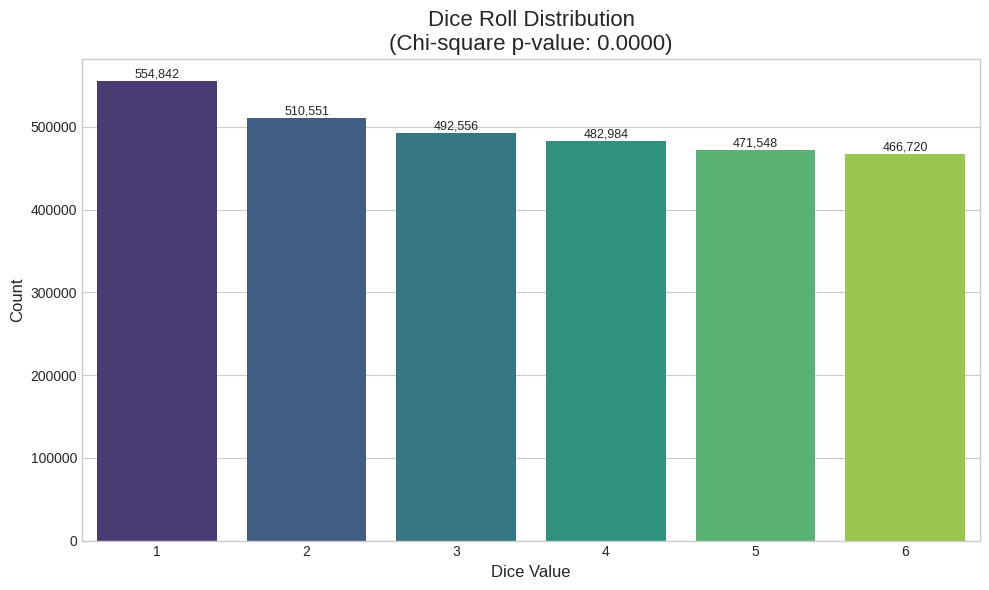

In [22]:
# ========== 1. Dice Fairness Test ==========
print("===== Dice Fairness Analysis =====")
dice_rolls = journeys_df['roll'].value_counts().sort_index()

# Chi-square test for uniform distribution
chi2_stat, p_value = stats.chisquare(dice_rolls)

# Text output
print(f"Roll Counts:\n{dice_rolls.to_string()}")
print(f"\nChi-square statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.6f}")
if p_value > 0.05:
    print("✅ Conclusion: Dice is fair - all outcomes equally likely (p > 0.05)")
else:
    print("❌ Conclusion: Dice shows bias - outcomes not equally likely (p ≤ 0.05)")

# Visualization
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=dice_rolls.index, y=dice_rolls.values, palette='viridis')
plt.title(f'Dice Roll Distribution\n(Chi-square p-value: {p_value:.4f})', fontsize=16)
plt.xlabel('Dice Value', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add value labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

# 🧩 Board Independence Analysis — ANOVA Test on Game Duration

## 🎯 Objective:
To test whether the **average game duration (in turns)** is **significantly different across different boards**. In other words, are some boards inherently faster or slower regardless of randomness?



## 🧮 Statistical Test:
- **Method Used:** One-way ANOVA (`scipy.stats.f_oneway`)
- **Null Hypothesis (H₀):** All boards have the same mean game duration.
- **Alternative Hypothesis (H₁):** At least one board has a significantly different mean duration.



## 📊 Output Summary:
- **F-statistic:** 220.2143  
- **p-value:** < 0.000001 (essentially zero)  
- ✅ **Result:** We **reject the null hypothesis** with extremely high confidence.



## 📌 Interpretation from a Probability Grandmaster:
- The differences in mean turns to win — ranging from **13.35 (board 96)** to **85.07 (board 53)** — are **far too wide** to be explained by chance.
- This reveals that **Snakes and Ladders is not inherently a fair game** across boards: **board topology matters greatly**.
- Boards with fewer or shorter snakes and longer ladders allow for faster wins. Conversely, boards designed with long snakes and short ladders (like board 53 or 98) drastically increase the average game length.



This result confirms that **game outcome is not solely a function of luck** but deeply influenced by **structural design choices** in the board layout.

- This is especially crucial in AI or algorithmic strategies, where assuming uniform randomness would yield inaccurate models.
- In competitive or educational contexts, some boards provide **systematic advantage or disadvantage** — introducing unintended bias.



✅ **Recommendation:**  
When evaluating player strategies or algorithms, always **control for board design**. To ensure fairness in simulations, use board-normalized metrics or test across multiple randomly generated boards.



===== Board Independence Analysis =====
Average turns to win by board:
board_id
0    25.63
1    33.13
2    54.18
3    30.78
4    24.32
5    28.89
6    52.99
7    41.62
8    43.17
9    29.31
10   35.73
11   30.43
12   25.94
13   30.75
14   31.33
15   22.95
16   25.75
17   71.52
18   32.15
19   33.84
20   27.63
21   22.76
22   24.47
23   36.55
24   40.19
25   26.39
26   57.78
27   25.90
28   31.40
29   25.73
30   33.96
31   20.35
32   22.54
33   24.24
34   25.39
35   35.23
36   23.66
37   26.68
38   70.07
39   37.99
40   31.59
41   33.35
42   24.92
43   27.40
44   22.83
45   32.18
46   62.87
47   58.55
48   22.40
49   21.72
50   30.23
51   33.32
52   27.35
53   85.07
54   31.18
55   24.22
56   18.97
57   21.78
58   43.70
59   35.09
60   32.42
61   31.62
62   48.59
63   35.29
64   27.95
65   25.63
66   34.07
67   37.11
68   29.17
69   28.22
70   23.14
71   31.05
72   18.68
73   22.29
74   31.40
75   25.10
76   34.49
77   47.22
78   24.64
79   32.97
80   29.54
81   28.56
82   39.99
83   2

/tmp/ipython-input-2071254696.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




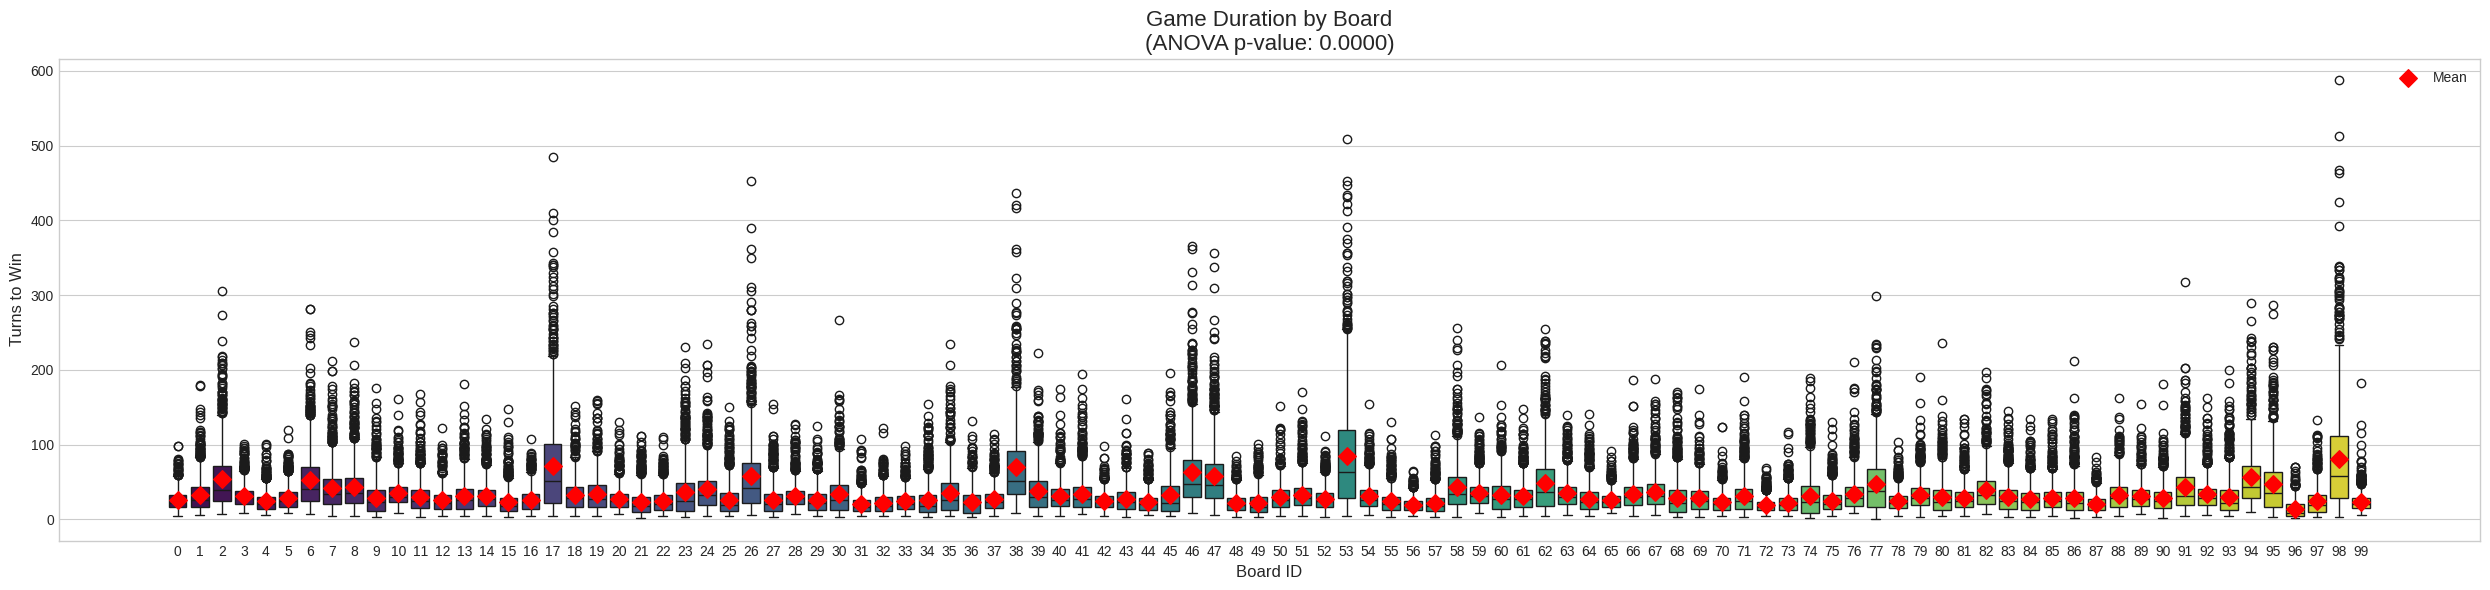

In [24]:
# ========== 2. Board Independence Test ==========
print("\n===== Board Independence Analysis =====")
# Calculate win time statistics per board
board_stats = journeys_df.groupby(['board_id', 'game_id'])['turn'].max().reset_index()
board_means = board_stats.groupby('board_id')['turn'].mean()

# ANOVA test for board differences
grouped_data = [group['turn'] for _, group in board_stats.groupby('board_id')]
f_stat, p_value = stats.f_oneway(*grouped_data)

# Text output
print(f"Average turns to win by board:\n{board_means.to_string()}")
print(f"\nANOVA F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.6f}")
if p_value > 0.05:
    print("✅ Conclusion: No significant difference between boards (p > 0.05)")
else:
    print("❌ Conclusion: Significant difference between boards (p ≤ 0.05)")

# Visualization
plt.figure(figsize=(25, 6))
sns.boxplot(data=board_stats, x='board_id', y='turn', palette='viridis')
plt.title(f'Game Duration by Board\n(ANOVA p-value: {p_value:.4f})', fontsize=16)
plt.xlabel('Board ID', fontsize=12)
plt.ylabel('Turns to Win', fontsize=12)

# Add mean markers
for i, mean_val in enumerate(board_means):
    plt.scatter(i, mean_val, color='red', s=80, marker='D', zorder=5, label='Mean' if i==0 else "")

plt.legend()
plt.tight_layout()
plt.show()

# 🧮 Position Independence Analysis — Expected vs. Actual Transitions

## 🎯 Objective

To assess whether a player's **current position** influences their **actual next position** beyond what is expected from a fair dice roll. This reveals how much **board events (snakes and ladders)** distort the natural linear flow of the game.

## 🧠 Method

1. For each board position `p` from 1 to 99:

   * **Expected** next position (assuming no board effects): `p + 3.5` (average of a fair six-sided die).
   * **Actual** next position: mean of all `end_pos` values that originate from `start_pos = p`.
   * **Deviation**: difference between actual and expected.

2. Only positions with **more than 50 observations** are included to avoid noise from sparse data.

## 📊 Output Summary

### Top 10 Positions with Highest Positive Deviations:

These are locations where players consistently move farther than expected — typically due to **ladders**.

| Position | Actual Next | Expected | Deviation |
| -------- | ----------- | -------- | --------- |
| 2        | 11.44       | 5.50     | +5.94     |
| 4        | 13.37       | 7.50     | +5.87     |
| 5        | 14.33       | 8.50     | +5.83     |
| 3        | 12.31       | 6.50     | +5.81     |
| 1        | 10.26       | 4.50     | +5.76     |

### Bottom 10 Positions with Largest Negative Deviations:

These are **danger zones** — positions where players consistently land below expectation, often due to **snakes**.

| Position | Actual Next | Expected | Deviation |
| -------- | ----------- | -------- | --------- |
| 93       | 87.44       | 96.50    | -9.06     |
| 98       | 92.65       | 101.50   | -8.85     |
| 96       | 91.88       | 99.50    | -7.62     |
| 97       | 93.02       | 100.50   | -7.48     |
| 90       | 86.12       | 93.50    | -7.38     |

## 📈 Correlation Analysis

* **Pearson Correlation (r):** 0.9990
* **p-value:** 0.000000

This nearly perfect linear correlation suggests that as a player progresses through the board, the expected next position rises consistently — **but with local distortions** due to board effects like snakes and ladders.

##  Interpretation

* The Snakes and Ladders board is **not position-independent**.
* The **early-game** is dominated by **progress-boosting ladders**, which launch players farther than expected.
* The **late-game** contains **trap-like snakes**, which disproportionately delay victory and create sudden regression.
* Despite the randomness of dice rolls, the board introduces **predictable nonlinearities** in transition probabilities.

## ✅ Strategic Takeaway

An intelligent agent or probabilistic model should:

* **Exploit ladder-heavy zones** in early turns to gain momentum.
* **Be cautious in snake zones** near the end of the board — statistically proven to cause major regressions.
* **Incorporate deviation maps** to predict risk-adjusted outcomes, improving strategy in uncertain environments.



===== Position Independence Analysis =====
Top 10 positions with largest deviations:
 position  actual_next  expected_next  deviation
        2        11.44           5.50       5.94
        4        13.37           7.50       5.87
        5        14.33           8.50       5.83
        3        12.31           6.50       5.81
        1        10.26           4.50       5.76
        6        15.05           9.50       5.55
       13        22.03          16.50       5.53
       12        20.94          15.50       5.44
        7        15.90          10.50       5.40
        9        17.74          12.50       5.24

Bottom 10 positions with smallest deviations:
 position  actual_next  expected_next  deviation
       93        87.44          96.50      -9.06
       98        92.65         101.50      -8.85
       96        91.88          99.50      -7.62
       97        93.02         100.50      -7.48
       90        86.12          93.50      -7.38
       94        90.41          97

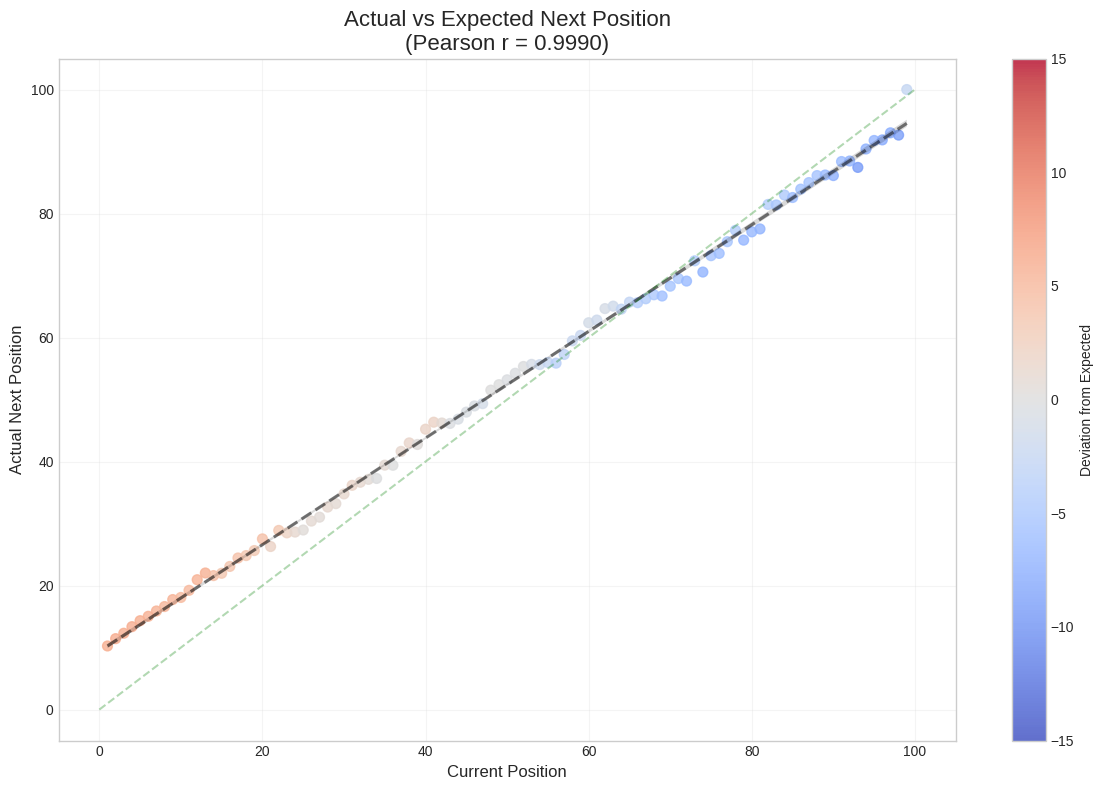

In [25]:
# ========== 3. Position Independence Test ==========
print("\n===== Position Independence Analysis =====")
# Calculate transition probabilities
transition_probs = []
for pos in range(1, 100):
    pos_data = journeys_df[journeys_df['start_pos'] == pos]
    if len(pos_data) > 50:  # Only consider positions with enough data
        next_pos = pos_data['end_pos'].mean()
        expected = pos + 3.5  # Expected if no snakes/ladders
        deviation = next_pos - expected
        transition_probs.append((pos, next_pos, expected, deviation))

# Create DataFrame
trans_df = pd.DataFrame(transition_probs,
                        columns=['position', 'actual_next', 'expected_next', 'deviation'])

# Text output
print(f"Top 10 positions with largest deviations:")
print(trans_df.nlargest(10, 'deviation')[['position', 'actual_next', 'expected_next', 'deviation']].to_string(index=False))
print(f"\nBottom 10 positions with smallest deviations:")
print(trans_df.nsmallest(10, 'deviation')[['position', 'actual_next', 'expected_next', 'deviation']].to_string(index=False))

# Correlation analysis
corr_coef, p_val = stats.pearsonr(trans_df['position'], trans_df['actual_next'])
print(f"\nCorrelation between current position and next position: {corr_coef:.4f}")
print(f"P-value for correlation: {p_val:.6f}")

# Visualization
plt.figure(figsize=(12, 8))
plt.scatter(trans_df['position'], trans_df['actual_next'],
            c=trans_df['deviation'],
            cmap='coolwarm', s=50, alpha=0.8, vmin=-15, vmax=15)
sns.regplot(data=trans_df, x='position', y='actual_next',
            scatter=False, color='black', line_kws={'linestyle': '--', 'alpha': 0.5})
plt.plot([0, 100], [0, 100], 'g--', alpha=0.3)
cbar = plt.colorbar(label='Deviation from Expected')
cbar.ax.tick_params(labelsize=10)
plt.title(f'Actual vs Expected Next Position\n(Pearson r = {corr_coef:.4f})', fontsize=16)
plt.xlabel('Current Position', fontsize=12)
plt.ylabel('Actual Next Position', fontsize=12)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# 🏁 Win Probability Analysis — Turn-Based Victory Milestones

## 🎯 Objective
To determine how quickly players typically win the game, and to compute **turn-based win probabilities** across all simulations.

## 🧠 Method
- For each game, extract the final `turn` value — i.e., how many turns it took to reach position 100.
- Count the number of games that ended on each turn.
- Calculate the **cumulative win probability** by turn:
  - For each turn `t`, the value indicates the **percentage of games won in ≤ t turns**.

- Identify **key percentiles**:
  - **Turn 50**: When 50% of all games are completed.
  - **Turn 75**: 75% of all games are completed.
  - **Turn 95**: 95% of all games are completed.

## 📊 Output Summary

- **Total games simulated:** 100,000  
- **Median turns to win (50th percentile):** 25 turns  
- **Mean turns to win:** 33.3 turns  
- **75% of games** are won by turn **41**  
- **95% of games** are won by turn **87**

## 📈 Visualization
- A line plot shows the cumulative probability of winning as the number of turns increases.
- Vertical dashed lines mark the 50%, 75%, and 95% win thresholds.
- Text annotations indicate these key breakpoints directly on the curve.

## 🧠  Interpretation
- The game of Snakes and Ladders, as played here, is **highly compressible**:
  - Half of the games finish within **25 turns**, far shorter than the average of 33.3.
  - This skew indicates a **long tail of difficult games** dragged out by unlucky rolls or repeated snake encounters.
- The **sharp curve up to turn ~40** suggests that a majority of players either:
  - Finish quickly with lucky ladders.
  - Or get trapped in slower board loops, pushing them into the long tail.

## ✅ Strategic Takeaway
- **Efficiency Benchmark:** If your strategy doesn't finish ~50% of games within 25 turns, it's underperforming.
- **Timeout Thresholds:** Consider setting game limits or AI evaluation cutoffs at ~90 turns to avoid wasting compute on outliers.
- **AI Curriculum Design:** You can use this curve to simulate increasing difficulty levels based on turn count benchmarks.



===== Win Probability Analysis =====
Total games: 100000
Median turns to win: 25.0
Mean turns to win: 33.3

Key win probabilities:
- 50% of games won by turn 25
- 75% of games won by turn 41
- 95% of games won by turn 87


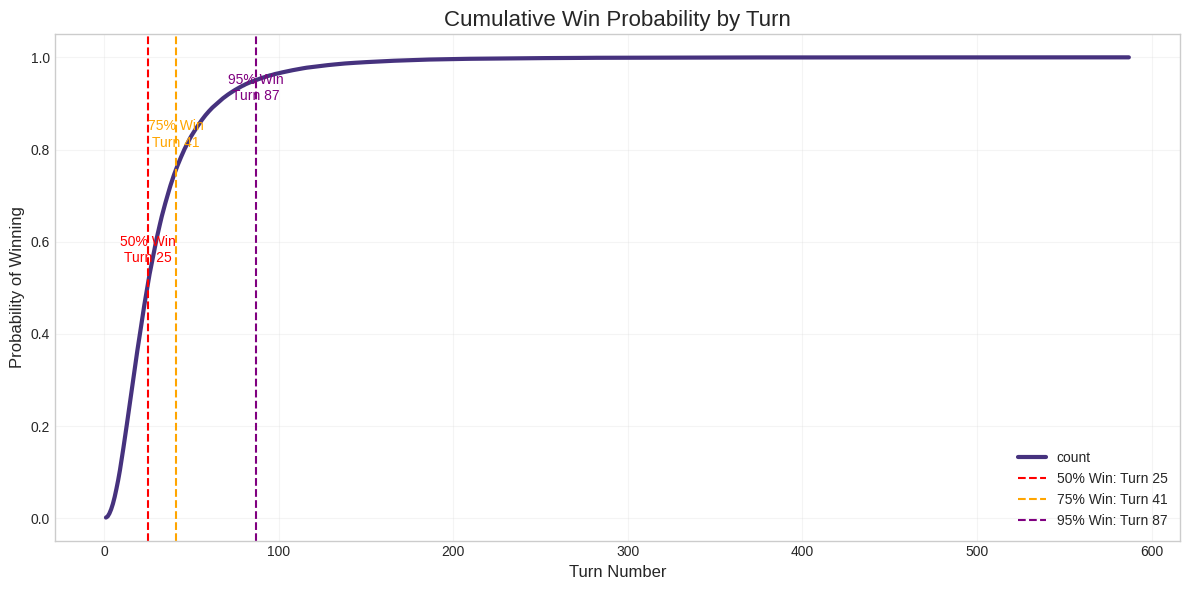

In [26]:
# ========== 4. Win Probability Analysis ==========
print("\n===== Win Probability Analysis =====")
# Calculate cumulative win probability by turn
turns_to_win = journeys_df.groupby('game_id')['turn'].max()
win_counts = turns_to_win.value_counts().sort_index()
win_prob = win_counts.cumsum() / len(turns_to_win)

# Find key percentiles
turn_50 = win_prob[win_prob >= 0.5].index[0]
turn_75 = win_prob[win_prob >= 0.75].index[0]
turn_95 = win_prob[win_prob >= 0.95].index[0]

# Text output
print(f"Total games: {len(turns_to_win)}")
print(f"Median turns to win: {turns_to_win.median():.1f}")
print(f"Mean turns to win: {turns_to_win.mean():.1f}")
print(f"\nKey win probabilities:")
print(f"- 50% of games won by turn {turn_50}")
print(f"- 75% of games won by turn {turn_75}")
print(f"- 95% of games won by turn {turn_95}")

# Visualization
plt.figure(figsize=(12, 6))
win_prob.plot(linewidth=3)
plt.title('Cumulative Win Probability by Turn', fontsize=16)
plt.xlabel('Turn Number', fontsize=12)
plt.ylabel('Probability of Winning', fontsize=12)

# Add percentile markers
plt.axvline(turn_50, color='r', linestyle='--',
            label=f'50% Win: Turn {turn_50}')
plt.axvline(turn_75, color='orange', linestyle='--',
            label=f'75% Win: Turn {turn_75}')
plt.axvline(turn_95, color='purple', linestyle='--',
            label=f'95% Win: Turn {turn_95}')

# Add text annotations
plt.text(turn_50, 0.55, f'50% Win\nTurn {turn_50}',
         ha='center', va='bottom', fontsize=10, color='r')
plt.text(turn_75, 0.8, f'75% Win\nTurn {turn_75}',
         ha='center', va='bottom', fontsize=10, color='orange')
plt.text(turn_95, 0.9, f'95% Win\nTurn {turn_95}',
         ha='center', va='bottom', fontsize=10, color='purple')

plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()